In [67]:
%matplotlib inline

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts

np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [112]:
#### Read in light curves, set an error:
data = np.loadtxt("lightcurve_bd/totalflux_r25_0degree.txt")

## Rotation period 2.5 hours 0 degrees (equator on)
flux = data[1]
flux = flux/np.median(flux)
time =  data[0]
sigma=0.001

<ErrorbarContainer object of 3 artists>

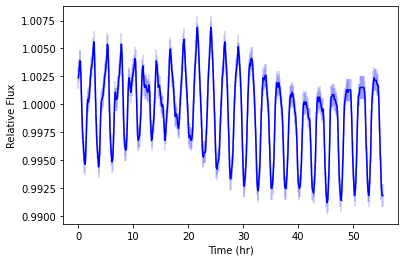

In [72]:
## plot to take a look
plt.plot(time,flux,color='blue')
plt.ylabel('Relative Flux')
plt.xlabel('Time (hr)')
plt.errorbar(time,flux,sigma,color='blue',alpha=0.2)

In [156]:
## now the fun part! 
## instantiate a map so we can do inference on this dataset
map = starry.Map(ydeg=5, reflected=False)
map.obl = 0
map.inc = 90


In [157]:
## set the data vector (the flux and the covariance matrix)
map.set_data(flux, C=sigma ** 2)

In [158]:
mu = np.empty(map.Ny)
mu[0] = 1
mu[1:] = 0
L = np.empty(map.Ny)
L[0] = 1e0
L[1:] = 1e-5
map.set_prior(L=L)

not totally sure what all of these values are! Might be good to check in the docs or paper:

In [159]:
nrot=max(time)/2.5
npts = len(time)
theta = np.linspace(0, 360 * nrot, npts)
# Rotate to an observer inclination
map.inc=90


# Position of the star relative to the planet in the orbital plane
t = np.reshape(time, (1, -1))
p = np.vstack((np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 0 * t))

ci = np.cos(map.inc * np.pi / 180)
si = np.sin(map.inc * np.pi / 180)
R = np.array([[1, 0, 0], [0, ci, -si], [0, si, ci]])
xs, ys, zs = R.dot(p)
kwargs = dict(theta=theta, xs=xs, ys=ys, zs=zs)




In [160]:
## we call solve, passing in the arguments (kwargs) above

In [161]:
%%time
mu, cho_cov = map.solve(**kwargs)

CPU times: user 123 ms, sys: 4.34 ms, total: 127 ms
Wall time: 126 ms


The `solve` method sets the map coefficicents to the maximum a posteriori (MAP) solution. Let's view this mean map:

/Users/johannavos/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


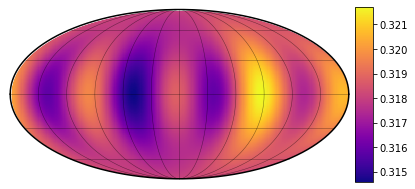

In [162]:
map.show( colorbar=True, projection="moll")

Note that the normalization is different (unphysical even!), but that's only because we normalized our flux vector. Because we divided out the maximum flux, there's nothing in the data telling us what the actual albedo of the surface is. (When modeling a real dataset, if we knew the distance from the planet to the star and modelled the flux in real units, we could easily fix this).

We can also draw a random sample from the posterior (which automatically sets the map amplitude and coefficients) by calling

In [163]:
np.random.seed(5)
map.draw()

/Users/johannavos/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


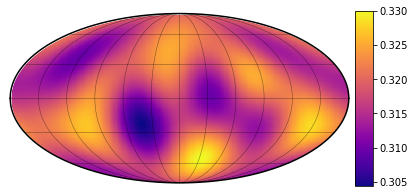

In [164]:
map.show( colorbar=True, projection="moll")

We can check how well the light curve is reproduced here (remember that even though our lightcurve is evolving, starry doesn't know that so we are getting a 'mean best fit'. Perhaps we could try running the code on different section of the light curve and seeing if any obvious changes occur?

No handles with labels found to put in legend.


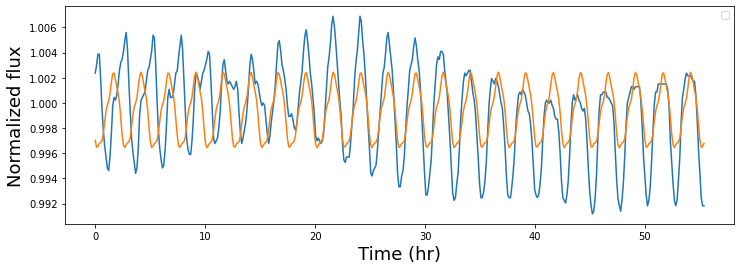

In [165]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(time, flux)
plt.plot(time, map.flux(**kwargs))
ax.set_xlabel("Time (hr)", fontsize=18)
ax.set_ylabel("Normalized flux", fontsize=18);
ax.legend()